In [1]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from tqdm.auto import tqdm
from pylab import rcParams
import os

# Задание 1.

* Вы - менеджер по продажам в нефтехимической компании.
* Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании.
* Ваши клиенты предпочитают формульный подход к ценообразованию и вам нужно предложить клиентам формулу цены на синтетический каучук, который может быть альтернативой натуральному каучуку с грейдом SMR 20.
* В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента…

In [2]:
# Из данных есть:
# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии)
# location - локация клиента
# volumes - закупаемые объемы
# formula - предпочитаемая формула расчета цены - скользящая средняя или среднее значение за месяц

customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'formula':'moving_average'
    },

    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'formula': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'formula': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'formula': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


In [3]:
df = pd.DataFrame(columns= ['date','grade','masa','rm','us','tone'])

for year in tqdm(['2020','2021','2022']):
    for mon in ['01','02','03','04','05','06','07','08','09','10','11','12']:
        url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={mon}&year={year}"
        res = requests.get(url)
        tmp = res.json()
        df=pd.concat([df,pd.DataFrame(pd.json_normalize(tmp))])

df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d')
print (f"Ближайшая дата, на которую есть информация -- {df['date'].max()}")

  0%|          | 0/3 [00:00<?, ?it/s]

Ближайшая дата, на которую есть информация -- 2022-09-29 00:00:00


In [5]:
df_dict = {}
for ticker in tqdm(['USDRUB=X', 'EURUSD=X', 'EURRUB=X']):
    df1 = yf.download(ticker)
    df1 = df1.Close.copy()
    df1 = df1.resample('M').mean()
    df_dict[ticker] = df1

  0%|          | 0/3 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
df_smr20 = df[df['grade'] == 'SMR 20']
df_smr20 = df_smr20.drop(['grade','masa','rm','tone'], axis=1)
df_smr20['date'] = pd.to_datetime(df_smr20['date'], format='%Y-%m-%d')
df_smr20 = df_smr20.set_index('date')
df_smr20['us'] = pd.to_numeric(df_smr20['us'])
mean_df_smr20 = df_smr20.resample('M').mean()
mean_df_smr20.columns = ['SMR_20_US']

In [8]:
main_df = pd.concat(df_dict.values(), axis=1)
main_df

,Close,Close,Close
Date,,,
2003-12-31,29.402609,1.231372,36.187222
2004-01-31,28.815714,1.260813,36.347455
2004-02-29,28.499000,1.264357,36.083011
2004-03-31,28.524644,1.226723,NaN
2004-04-30,28.684000,1.199692,34.990002
...,...,...,...
2022-05-31,65.422944,1.057322,68.104363
2022-06-30,60.146091,1.057670,60.378959
2022-07-31,61.413657,1.019509,62.204667


In [9]:
main_df.columns = ['USDRUB', 'EURUSD', 'EURRUB']
#main_df = main_df.loc['2019-01-31':'2022-08-31'].copy()

In [10]:
main_df = mean_df_smr20.add(main_df, fill_value=0)

In [11]:
main_df.head()

,EURRUB,EURUSD,SMR_20_US,USDRUB
2003-12-31,36.187222,1.231372,NaN,29.402609
2004-01-31,36.347455,1.260813,NaN,28.815714
2004-02-29,36.083011,1.264357,NaN,28.499000
2004-03-31,NaN,1.226723,NaN,28.524644
2004-04-30,34.990002,1.199692,NaN,28.684000


In [12]:
main_df['SMR20_PRICE_EUR'] = main_df.SMR_20_US * (1/main_df.EURUSD) + 400
main_df['SMR20_PRICE_USD'] = main_df.SMR_20_US + 400
main_df['SMR20_PRICE_EUR_EU'] = main_df['SMR20_PRICE_EUR'] + EU_LOGISTIC_COST_EUR
main_df['SMR20_PRICE_USD_CN'] = main_df['SMR20_PRICE_USD'] + CN_LOGISTIC_COST_USD
main_df['SMR20_PRICE_EUR_EU_MA'] = main_df.SMR20_PRICE_EUR_EU.rolling(window=3).mean()

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,7

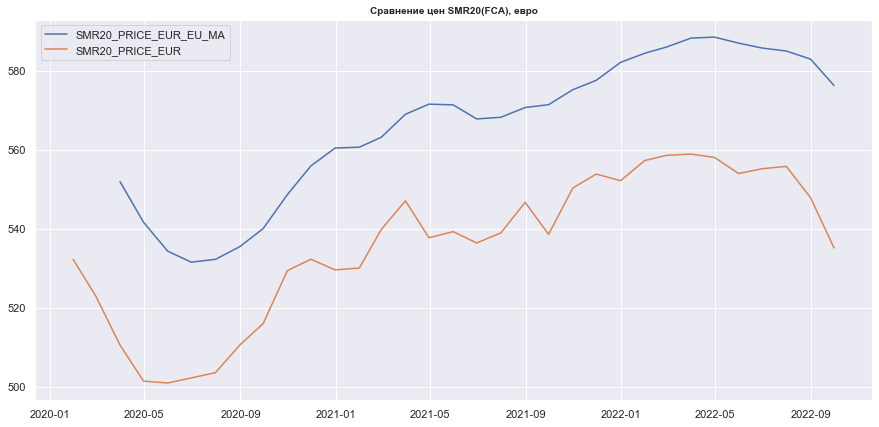

In [16]:
# График с базовой ценой(на заводе) в евро
plt.title('Сравнение цен SMR20(FCA), евро', fontsize=10, fontweight='bold')
plt.plot(main_df['SMR20_PRICE_EUR_EU_MA'], label='SMR20_PRICE_EUR_EU_MA')
plt.plot(main_df['SMR20_PRICE_EUR'], label='SMR20_PRICE_EUR')
plt.legend()
plt.show()

In [23]:
discounts = {100: 0.01, 300: 0.05, 301: 0.1}

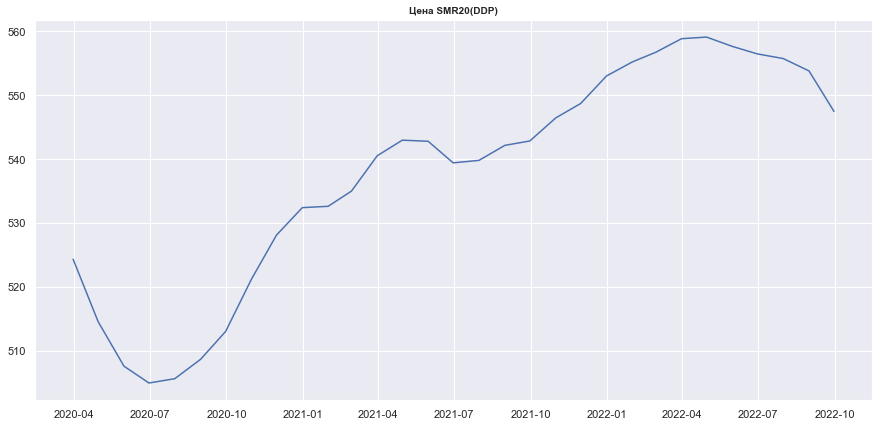

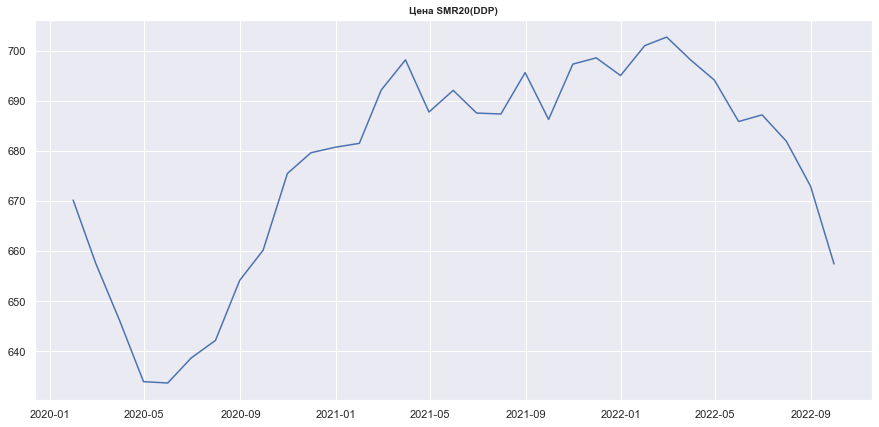

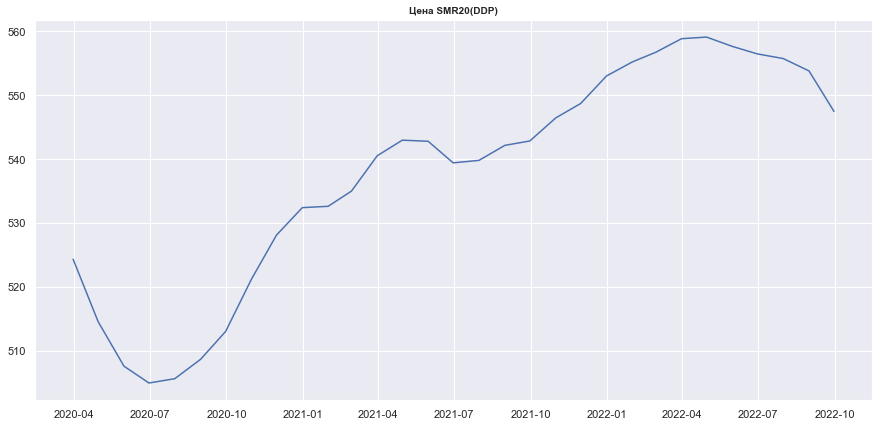

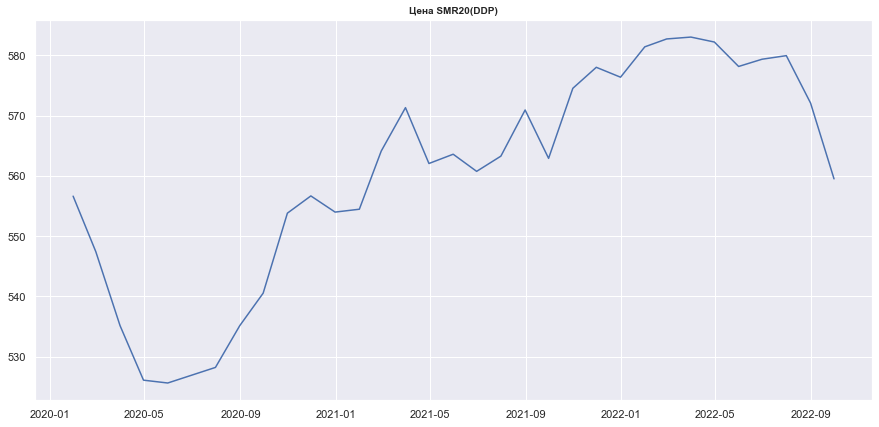

In [27]:
with pd.ExcelWriter('price_proposals.xlsx', engine = 'xlsxwriter') as writer:
    for client, v in customers.items():

        disc = 0.0
        if v.get('location') == "EU":
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            if v.get('formula') == 'monthly':
                client_price = main_df['SMR20_PRICE_EUR_EU'] * (1-disc)
            elif v.get('formula') == 'moving_average':
                client_price = main_df['SMR20_PRICE_EUR_EU_MA'] * (1-disc)

        elif v.get('location') == 'CN':
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            client_price = main_df['SMR20_PRICE_USD_CN'] * (1-disc)

        
        client_price.to_excel(writer, sheet_name=client)
        # Добавляем график с ценой
        plot_path = f'{client}_SMR20.png'
        plt.title('Цена SMR20(DDP)', fontsize=10, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()

    for k,v in customers.items():
        worksheet = writer.sheets[k]
        worksheet.insert_image('C2',f"{k}_SMR20.png")

for k,v in customers.items():
    if os.path.exists(f"{k}_SMR20.png"):
        os.remove(f"{k}_SMR20.png")
        
if not os.path.exists('client_wbp_price_proposals'):
    os.mkdir(price_proposals_path)

In [21]:
v.get('volumes')

200

# Задание 2. Продолжение

Клиенты согласились на ваше предложение.
### Что нужно сделать?
Вам нужно написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно.



* В результате должен быть скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


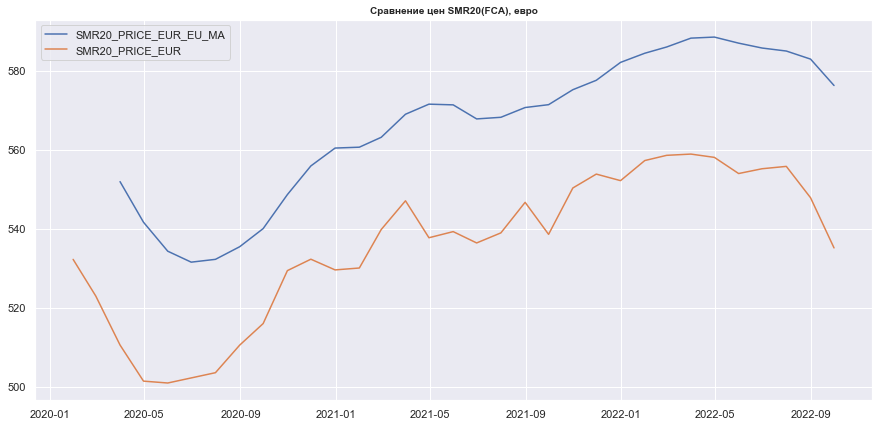

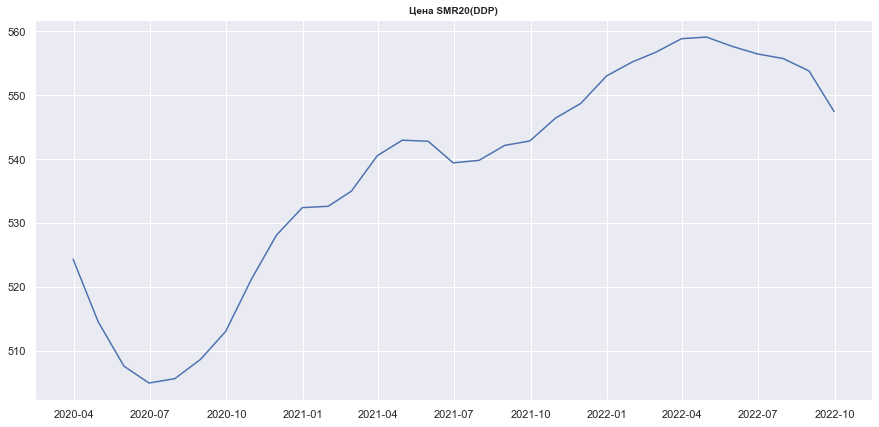

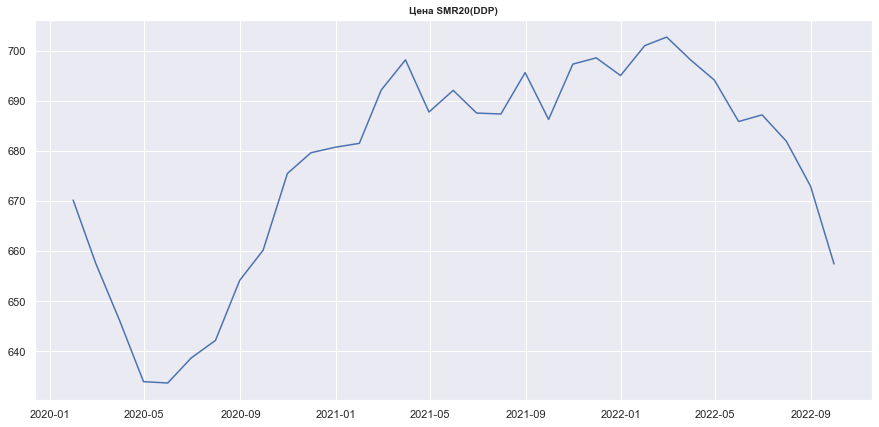

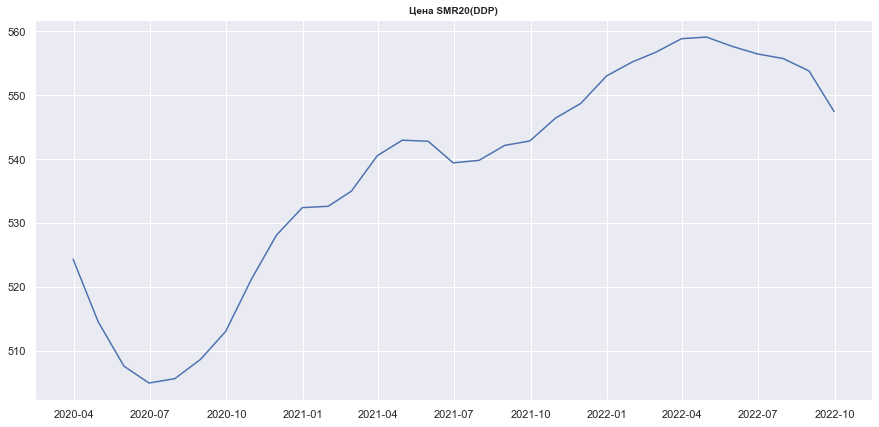

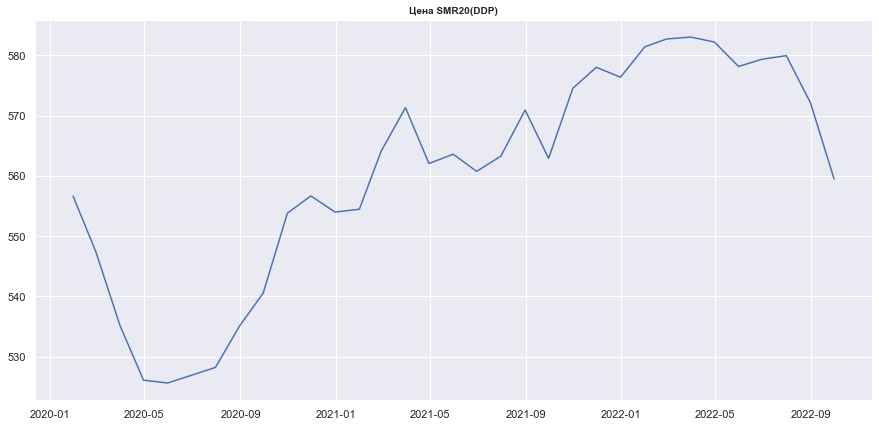

In [31]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from tqdm.auto import tqdm
import os
from pylab import rcParams
rcParams['figure.figsize'] = 15,7

# Из данных есть:
# Затраты на производство
df = pd.DataFrame(columns= ['date','grade','masa','rm','us','tone'])

for year in tqdm(['2020','2021','2022']):
    for mon in ['01','02','03','04','05','06','07','08','09','10','11','12']:
        url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={mon}&year={year}"
        res = requests.get(url)
        tmp = res.json()
        df=pd.concat([df,pd.DataFrame(pd.json_normalize(tmp))])

df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d')

df_dict = {}
for ticker in tqdm(['USDRUB=X', 'EURUSD=X', 'EURRUB=X']):
    df1 = yf.download(ticker)
    df1 = df1.Close.copy()
    df1 = df1.resample('M').mean()
    df_dict[ticker] = df1

df_smr20 = df[df['grade'] == 'SMR 20']
df_smr20 = df_smr20.drop(['grade','masa','rm','tone'], axis=1)
df_smr20['date'] = pd.to_datetime(df_smr20['date'], format='%Y-%m-%d')
df_smr20 = df_smr20.set_index('date')
df_smr20['us'] = pd.to_numeric(df_smr20['us'])
mean_df_smr20 = df_smr20.resample('M').mean()
mean_df_smr20.columns = ['SMR_20_US']

main_df = pd.concat(df_dict.values(), axis=1)
main_df.columns = ['USDRUB', 'EURUSD', 'EURRUB']
main_df = mean_df_smr20.add(main_df, fill_value=0)

main_df['SMR20_PRICE_EUR'] = main_df.SMR_20_US * (1/main_df.EURUSD) + 400
main_df['SMR20_PRICE_USD'] = main_df.SMR_20_US + 400
main_df['SMR20_PRICE_EUR_EU'] = main_df['SMR20_PRICE_EUR'] + EU_LOGISTIC_COST_EUR
main_df['SMR20_PRICE_USD_CN'] = main_df['SMR20_PRICE_USD'] + CN_LOGISTIC_COST_USD
main_df['SMR20_PRICE_EUR_EU_MA'] = main_df.SMR20_PRICE_EUR_EU.rolling(window=3).mean()

plt.title('Сравнение цен SMR20(FCA), евро', fontsize=10, fontweight='bold')
plt.plot(main_df['SMR20_PRICE_EUR_EU_MA'], label='SMR20_PRICE_EUR_EU_MA')
plt.plot(main_df['SMR20_PRICE_EUR'], label='SMR20_PRICE_EUR')
plt.legend()
plt.show()

discounts = {100: 0.01, 300: 0.05, 301: 0.1}

with pd.ExcelWriter('price_proposals.xlsx', engine = 'xlsxwriter') as writer:
    for client, v in customers.items():

        disc = 0.0
        if v.get('location') == "EU":
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            if v.get('formula') == 'monthly':
                client_price = main_df['SMR20_PRICE_EUR_EU'] * (1-disc)
            elif v.get('formula') == 'moving_average':
                client_price = main_df['SMR20_PRICE_EUR_EU_MA'] * (1-disc)

        elif v.get('location') == 'CN':
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            client_price = main_df['SMR20_PRICE_USD_CN'] * (1-disc)

        
        client_price.to_excel(writer, sheet_name=client)
        # Добавляем график с ценой
        plot_path = f'{client}_SMR20.png'
        plt.title('Цена SMR20(DDP)', fontsize=10, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()

    for k,v in customers.items():
        worksheet = writer.sheets[k]
        worksheet.insert_image('C2',f"{k}_SMR20.png")

for k,v in customers.items():
    if os.path.exists(f"{k}_SMR20.png"):
        os.remove(f"{k}_SMR20.png")
        
if not os.path.exists('client_wbp_price_proposals'):
    os.mkdir(price_proposals_path)


# Задание 3. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

### Что нужно сделать?
* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ
* Помните о PEP8

# Задание 4. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

### Что нужно сделать?
* Создайте отдельный пакет, который можно устанавливать с помощью pip
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в свой репозиторий

In [ ]:
# !pip install yourpackage
# import yourpackage